In [13]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ---------------------------------------------------------------------------
# 1. Grid on the 3-class simplex  (p1, p2, p3 = 1-p1-p2)
# ---------------------------------------------------------------------------
RES = 101
p1_lin = np.linspace(0, 1, RES)
p2_lin = np.linspace(0, 1, RES)
P1, P2 = np.meshgrid(p1_lin, p2_lin)
mask   = (P1 + P2) <= 1             # keep only points inside the simplex
P3     = 1.0 - P1 - P2
P1m, P2m, P3m = [np.where(mask, a, np.nan) for a in (P1, P2, P3)]

# ---------------------------------------------------------------------------
# 2. Pre-compute surfaces for every possible true class
# ---------------------------------------------------------------------------
eps = 1e-12
def neg_log(p): return -np.log(np.clip(p, eps, 1.0))

def surfaces(y_true):
    """Return (neg_log_surface, brier_surface) for true class y_true."""
    probs   = [P1m, P2m, P3m]
    p_true  = probs[y_true]
    one_hot = [1 if i == y_true else 0 for i in range(3)]
    neglog  = neg_log(p_true)
    brier   = sum((p - y)**2 for p, y in zip(probs, one_hot))
    return neglog, brier

neglog_surfs, brier_surfs = zip(*(surfaces(c) for c in range(3)))

# ---------------------------------------------------------------------------
# 3. Build the locality-diagnostic slice for each class
# ---------------------------------------------------------------------------
p_star = 0.5                                 # fixed prob. for the true class
SLICE_RES = 100
ts = np.linspace(0, 1 - p_star, SLICE_RES)   # how much mass is shuffled

slice_points = []
for y in range(3):
    # allocate empty arrays
    xs, ys, zs_log, zs_brier = [], [], [], []

    for t in ts:                             # distribute remaining mass
        if y == 0:
            p1, p2, p3 = p_star, t, 1 - p_star - t
        elif y == 1:
            p1, p2, p3 = t, p_star, 1 - p_star - t
        else:
            p1, p2, p3 = t, 1 - p_star - t, p_star

        xs.append(p1)
        ys.append(p2)
        zs_log.append(neg_log(p_star))        # constant!
        zs_brier.append((p1-1)**2 + p2**2 + p3**2)

    slice_points.append((xs, ys, zs_log, zs_brier))

# ---------------------------------------------------------------------------
# 4. Assemble the figure:  2 surfaces + 2 slice-lines per frame
# ---------------------------------------------------------------------------
fig = make_subplots(
        rows=1, cols=2, horizontal_spacing=0.06,
        specs=[[{'type': 'surface'}, {'type':'surface'}]],
        subplot_titles=("Negative log-score (local)",
                        "Brier score (non-local)")
      )

# Initial traces ( true class = 0 )
fig.add_trace(go.Surface(x=P1m, y=P2m, z=neglog_surfs[0],
                         colorscale='RdBu_r', showscale=False),
              row=1, col=1)
fig.add_trace(go.Surface(x=P1m, y=P2m, z=brier_surfs[0],
                         colorscale='RdBu_r', showscale=False),
              row=1, col=2)

# slice lines (red on log surface, blue on Brier surface)
xs, ys, zl, zb = slice_points[0]
fig.add_trace(go.Scatter3d(x=xs, y=ys, z=zl,
                           mode='lines',
                           line=dict(color='purple', width=6),
                           showlegend=False),
              row=1, col=1)
fig.add_trace(go.Scatter3d(x=xs, y=ys, z=zb,
                           mode='lines',
                           line=dict(color='purple', width=6),
                           showlegend=False),
              row=1, col=2)

# ---------------------------------------------------------------------------
# 5. Animation frames and slider
# ---------------------------------------------------------------------------
frames, steps = [], []
for c in range(3):
    xs, ys, zl, zb = slice_points[c]
    frames.append(
        go.Frame(name=f'class {c+1}',
                 data=[
                     go.Surface(z=neglog_surfs[c]),    # traces 0
                     go.Surface(z=brier_surfs[c]),      # 1
                     go.Scatter3d(x=xs, y=ys, z=zl),    # 2
                     go.Scatter3d(x=xs, y=ys, z=zb)     # 3
                 ])
    )
    steps.append(
        dict(method='animate',
             args=[[f'class {c+1}'],
                   {"frame":  {"duration": 0, "redraw": True},
                    "mode":   "immediate"}],
             label=str(c+1))
    )

fig.frames = frames

fig.update_layout(
    width=1200, height=700,
    title="Local vs. non-local proper scoring rules on the 3-class simplex",
    margin=dict(l=0, r=0, t=60, b=0),
    scene=dict(xaxis_title='p1',
               yaxis_title='p2',
               zaxis_title='score',
               aspectmode='cube'),
    scene2=dict(xaxis_title='p1',
                yaxis_title='p2',
                zaxis_title='score',
                aspectmode='cube')
)

fig.show()

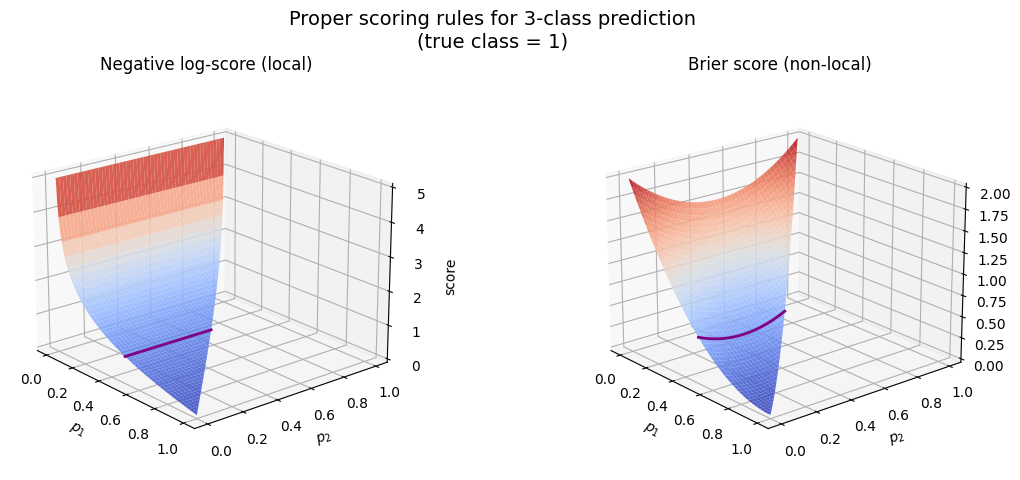

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D     # noqa: F401  (registers the 3-D proj.)

# --------------------------------------------------------------------
# 1. Build a grid over the 2-D simplex  p1 ≥ 0, p2 ≥ 0, p1 + p2 ≤ 1
# --------------------------------------------------------------------
RES = 150                                   # grid resolution
p1_lin = np.linspace(0, 1, RES)
p2_lin = np.linspace(0, 1, RES)
P1, P2 = np.meshgrid(p1_lin, p2_lin)
mask   = (P1 + P2) <= 1.0                   # keep only points inside the simplex
P3     = 1.0 - P1 - P2

# Turn everything that lies outside the simplex into masked values
P1m, P2m, P3m = [np.ma.array(a, mask=~mask) for a in (P1, P2, P3)]

# --------------------------------------------------------------------
# 2. Scores for  true class = 0   (i.e. class 1 in human counting)
# --------------------------------------------------------------------
eps = 1e-12
neg_log_surface = np.clip(np.ma.array(-np.log(np.clip(P1m, eps, 1.0)), mask=~mask), 0, a_max=5)
brier_surface   = (P1m - 1)**2 + P2m**2 + P3m**2

# --------------------------------------------------------------------
# 3. Build a 1-D slice: keep p_true = 0.5 and move remaining mass
# --------------------------------------------------------------------
p_star = 0.5                                # fixed probability for the true class
num_pts = 200
t = np.linspace(0, 1 - p_star, num_pts)     # amount of mass shifted
# For true class 0 the slice runs   (p1, p2, p3) = (p_star, t, 1-p_star-t)
p1_slice = np.full_like(t, p_star)
p2_slice = t
p3_slice = 1.0 - p_star - t

slice_neglog = -np.log(p_star) * np.ones_like(t)     # a flat line!
slice_brier  = (p1_slice - 1)**2 + p2_slice**2 + p3_slice**2

# --------------------------------------------------------------------
# 4. Plot
# --------------------------------------------------------------------
fig = plt.figure(figsize=(12, 5))

# ---- Negative log-score surface ------------------------------------
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(P1m, P2m, neg_log_surface,
                         cmap='coolwarm', edgecolor='none', alpha=0.9, vmin = 0, vmax = 5)
ax1.plot(p1_slice, p2_slice, slice_neglog,
         color='purple', linewidth=2, label=r'Slice, $p_1=0.5$', zorder = 10)
ax1.set_title('Negative log-score (local)')
ax1.set_xlabel('$p_1$')
ax1.set_ylabel('$p_2$')
ax1.set_zlim(0,5)
ax1.set_zlabel('score')
ax1.view_init(elev=20, azim=-40)            # nice viewing angle
# ax1.legend(loc='upper left')

# ---- Brier score surface -------------------------------------------
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(P1m, P2m, brier_surface,
                         cmap='coolwarm', edgecolor='none', alpha=0.9)
ax2.plot(p1_slice, p2_slice, slice_brier,
         color='purple', linewidth=2, label=r'Slice, $p_1=0.5$', zorder = 10)
ax2.set_title('Brier score (non-local)')
ax2.set_xlabel('$p_1$')
ax2.set_ylabel('$p_2$')
ax2.set_zlabel('score')
ax2.view_init(elev=20, azim=-40)
# ax2.legend(loc='upper left')

fig.suptitle('Proper scoring rules for 3-class prediction\n'
             '(true class = 1)', y=0.95,
             fontsize=14)
plt.tight_layout()
plt.savefig('./locality.png', transparent = True, dpi = 300)